In [55]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.preprocessing import MinMaxScaler
import torch
savepath = f"data"

In [50]:
def get_dtypes(data):
    data[data.dtypes[data.dtypes=='object'].index] = data[data.dtypes[data.dtypes=='object'].index].fillna(-1).astype('int')
    data[data.dtypes[data.dtypes=='bool'].index] = data[data.dtypes[data.dtypes=='bool'].index].fillna(-1).astype('int')

    return data


In [51]:
files = glob.glob(f'{savepath}/*')

labels = pd.read_csv(f'{savepath}/karma_data.csv',index_col=0)


address = pd.read_csv(f'{savepath}/address',index_col=0)
address = address.drop({'block_timestamp'},axis=1)#.join( ((pd.to_datetime('2023-04-15',utc=True) - pd.to_datetime(address['block_timestamp'])).dt.total_seconds()/60/24).round(0))
address = address.drop({'metadata_block_timestamp'},axis=1)#.join( ((pd.to_datetime('2023-04-15',utc=True) - pd.to_datetime(address['metadata_block_timestamp'])).dt.total_seconds()/60/24).round(0))

address = address.rename({'block_timestamp':'days_since_profile_created', 'metadata_block_timestamp':'days_since_metadata_changed'},axis=1)



dispatcher = pd.read_csv(f'{savepath}/dispatcher_data',index_col=0)
dispatcher = dispatcher.drop(['profile_dispatcher_address','dispatcher_setup_timestamp'],axis=1).join(pd.get_dummies(dispatcher['profile_dispatcher_address'])).join( ((pd.to_datetime('2023-04-15',utc=True) - pd.to_datetime(dispatcher['dispatcher_setup_timestamp'])).dt.total_seconds()/60/24).round(0))
dispatcher = dispatcher.rename({'dispatcher_setup_timestamp':'days_since_dispatcher_changed'},axis=1)

profile_data = pd.merge(dispatcher,address, on='profile_id', how='outer')


worldcoin_human = pd.read_csv(f'{savepath}/worldcoin_human_check',index_col=0)
worldcoin_human['worldcoin_human']=True
profile_data = pd.merge(profile_data,worldcoin_human, on='profile_id', how='outer')

aggregated_stats = pd.read_csv(f'{savepath}/aggregated_stats',index_col=0)
profile_data = pd.merge(profile_data,aggregated_stats, on='profile_id', how='outer')



def read_insight_data(profile_data, name,group_col='profile_id'):
    profile_data.copy()
    df = pd.read_csv(f'{savepath}/{name}',index_col=0,skiprows=[0,2])
    df.columns = [f'{i}_{name}' for i in df.columns]
    profile_data = pd.merge(profile_data,df, left_on=group_col,right_index=True, how='outer')
    return profile_data

profile_data = read_insight_data(profile_data, name='post_data_insights')

profile_data = read_insight_data(profile_data, name='comment_data_insights')

profile_data = read_insight_data(profile_data, name='mirror_data_insights')

profile_data = read_insight_data(profile_data, name='like_data_insights')


most_used_app = pd.read_csv(f'{savepath}/most_used_app',index_col=0)
most_used_app = most_used_app.join(pd.get_dummies(most_used_app[['app_id_highest_posts','app_id_highest_comments']])).drop(['app_id_highest_posts','app_id_highest_comments'],axis=1)
profile_data = pd.merge(profile_data,most_used_app, on='profile_id', how='outer')


ens_address = pd.read_csv(f'{savepath}/ens_address',index_col=0)
ens_address['ens']=True

proof_of_humanity = pd.read_csv(f'{savepath}/proof_of_humanity',index_col=0)
proof_of_humanity['proof_of_humanity']=True

sybil_dot_org_address_verified_twitter = pd.read_csv(f'{savepath}/sybil_dot_org_address_verified_twitter',index_col=0)
sybil_dot_org_address_verified_twitter['sybil_dot_org_address_verified_twitter']=True

address_data = pd.merge(ens_address,proof_of_humanity, on='address',how='outer')
address_data = pd.merge(address_data,sybil_dot_org_address_verified_twitter, on='address',how='outer')

address_data = read_insight_data(address_data, name='collect_data_insights',group_col='address')

address_data = read_insight_data(address_data, name='paid_collect_data_insights',group_col='address')



data = profile_data.merge(address_data,on='address',how='outer').drop('address',axis=1)



def intify(x):
    return int(x,16)



data = data.dropna(subset=['profile_id'])
data['id'] = data['profile_id'].apply(intify)
data = data.set_index('profile_id')

data = data.merge(labels,on='id',how='inner')
data = data.fillna(-1)
data.head()

,0x112b57A293d99b79Fe360Af042bb3bfFc824Ab3a,0x25418Bcf53dAe1167cD5d0cad34Eec31C0C37E41,0x3530c7CAc2E47F27bA82a5d0D3671181171292DB,0x45F71328a415129CB25e3917e70f5BCA346C6151,0x46fAf146C4683663667af868dFc2F98ADc27fBd6,0x57B7bf6f792a6181Ec5aFB88cE7bcE330a9d1b67,0x62D0e168e35f87a1dB804C2b2daf63AE4D195cD1,0x6bC45934A408f7151093479bf59933cD3B75701d,0x761010EFc8826fFdcb8Ad005BD935698ed38DfE7,0x76D4fFdA8c66864FA07f0a285B8E01E11b4Bb7b3,...,Unnamed: 20_paid_collect_data_insights,Unnamed: 21_paid_collect_data_insights,Unnamed: 22_paid_collect_data_insights,Unnamed: 23_paid_collect_data_insights,Unnamed: 24_paid_collect_data_insights,id,score,rank,handle,followersCount
0,False,False,False,True,False,False,False,False,False,False,...,-1.0,-1.0,-1.0,-1.0,-1.0,44206,1.204615e-32,73917,lalalisa.lens,4
1,False,False,False,False,True,False,False,False,False,False,...,-1.0,-1.0,-1.0,-1.0,-1.0,63491,2.780876e-04,357,wearenewt.lens,99
2,False,False,False,False,False,False,False,True,False,False,...,-1.0,-1.0,-1.0,-1.0,-1.0,42808,1.055264e-03,101,korudao.lens,7233
3,False,False,False,True,False,False,False,False,False,False,...,-1.0,-1.0,-1.0,-1.0,-1.0,58734,6.004227e-33,82601,lenstyle.lens,3
4,False,False,False,False,False,False,True,False,False,False,...,-1.0,-1.0,-1.0,-1.0,-1.0,7059,5.603351e-32,55999,edaen.lens,11


In [74]:
bad = data.dropna(subset=['rank','total_mirrors']).query('total_mirrors>100').sort_values(by='rank').tail(500).drop(labels.columns,axis=1)
good = pd.concat([data[data['worldcoin_human']==True].drop(labels.columns,axis=1),data.sort_values(by='rank').head(500).drop(labels.columns,axis=1)],axis=0).copy()
bad['label'] = 0
good['label'] = 1

training_data = pd.concat([bad,good])
validation_data = data.drop(training_data.index).drop(labels.columns,axis=1)


In [75]:
training_data = get_dtypes(training_data)
validation_data = get_dtypes(validation_data)

X_train, X_test, y_train, y_test = train_test_split(training_data.drop('label',axis=1), training_data['label'], test_size=0.33, random_state=42)
max_epochs = 1000


training_data.dtypes.value_counts()

int64      160
float64    150
Name: count, dtype: int64

In [76]:
mc = MinMaxScaler()
X_train.shape

(705, 309)

In [77]:

# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    verbose=5,
)

/Users/kimmo/anaconda3/envs/lens-bot-or-not/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [78]:
unsupervised_model.fit(
     X_train=mc.fit_transform(validation_data.values),
     eval_set=[mc.transform(training_data.drop('label',axis=1).values)],
    
       

    max_epochs=max_epochs , patience=10,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
) 

epoch 0  | loss: 203.43513| val_0_unsup_loss_numpy: 2.243230104446411|  0:00:09s
epoch 5  | loss: 0.48646 | val_0_unsup_loss_numpy: 0.5446400046348572|  0:00:56s
epoch 10 | loss: 2125.627| val_0_unsup_loss_numpy: 0.5199999809265137|  0:01:44s
epoch 15 | loss: 3416.7085| val_0_unsup_loss_numpy: 0.4950000047683716|  0:02:36s
epoch 20 | loss: 0.39043 | val_0_unsup_loss_numpy: 0.5337600111961365|  0:03:24s
epoch 25 | loss: 0.42153 | val_0_unsup_loss_numpy: 0.5139600038528442|  0:04:13s

Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_unsup_loss_numpy = 0.48787999153137207


/Users/kimmo/anaconda3/envs/lens-bot-or-not/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [79]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-3),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax', # This will be overwritten if using pretrain model
                       verbose=5,
                      )

/Users/kimmo/anaconda3/envs/lens-bot-or-not/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [80]:
clf.fit(
    X_train=mc.fit_transform(X_train.values), y_train=y_train.values,
    eval_set=[(mc.transform(X_train.values), y_train.values), (mc.transform(X_test.values), y_test.values)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss'],
    max_epochs=max_epochs , patience=5,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=unsupervised_model,
    
) 

/Users/kimmo/anaconda3/envs/lens-bot-or-not/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/Users/kimmo/anaconda3/envs/lens-bot-or-not/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 1.418   | train_logloss: 2.30961 | valid_logloss: 2.45723 |  0:00:00s
epoch 5  | loss: 1.24779 | train_logloss: 2.25662 | valid_logloss: 2.44462 |  0:00:00s
epoch 10 | loss: 0.92009 | train_logloss: 2.05172 | valid_logloss: 2.24491 |  0:00:01s
epoch 15 | loss: 0.96651 | train_logloss: 1.98892 | valid_logloss: 2.1632  |  0:00:01s
epoch 20 | loss: 0.79733 | train_logloss: 1.84807 | valid_logloss: 2.00223 |  0:00:02s
epoch 25 | loss: 0.72668 | train_logloss: 1.73092 | valid_logloss: 1.92202 |  0:00:02s
epoch 30 | loss: 0.70555 | train_logloss: 1.64668 | valid_logloss: 1.86704 |  0:00:03s

Early stopping occurred at epoch 34 with best_epoch = 29 and best_valid_logloss = 1.86479


/Users/kimmo/anaconda3/envs/lens-bot-or-not/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [81]:
from sklearn.metrics import roc_auc_score


In [82]:
preds = clf.predict_proba(mc.transform(validation_data.values))
# test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(mc.transform(X_test.values))
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_test)

print(f"BEST VALID SCORE : {clf.best_cost}")
#print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE : 1.8647883165375274


In [83]:
pd.Series(preds.argmax(1)).value_counts()

1    69277
0    29683
Name: count, dtype: int64

<Axes: xlabel='rank', ylabel='label'>

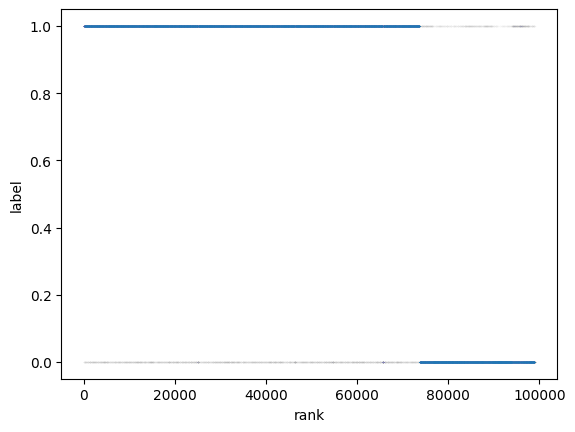

In [84]:
pd.Series(preds.argmax(1),name='label').reset_index().join(labels).plot.scatter(x='rank',y='label',alpha=0.01,s=0.1)

In [86]:
pd.Series(preds[:,1],name='label').reset_index().join(labels).head(20)

,index,label,score,rank,handle,followersCount,id
0,0,0.849658,0.064284,1,stani.lens,57607,5
1,1,0.982385,0.059850,2,bradorbradley.lens,33082,36
2,2,0.954938,0.059520,3,christina.lens,28154,142
3,3,0.918189,0.055198,4,blackdave.lens,819,36284
4,4,0.850522,0.054165,5,chriscomrie.lens,4917,73557
5,5,0.693938,0.053637,6,levychain.lens,13995,3297
6,6,0.972705,0.052514,7,ryanfox.lens,1266,90724
7,7,0.032327,0.052446,8,goodkrak.lens,444,89805
8,8,0.939937,0.052177,9,jamesfinnerty.lens,1177,105878
9,9,0.951512,0.051787,10,cristinaspinei.lens,5157,4231
